In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns

# Data crunching libraries
import numpy as np
import pandas as pd

# All utilities
import warnings
# filter warnings
warnings.filterwarnings('ignore')
import datetime
import time
import os
import zipfile
import sys
import re
import glob
import cv2
import gdown

# SK-learn libraries for learning.
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

**Choose a random image to display for each sign**

*   In order to check the quality of the images from the source we randomly select an image for each of the 29 characters (26 letters", "nothing", "space", and delete"
*   In addition to displaying the randomly selected image for each character we also run each of these images through "cv.calcHist()" that provides the RGB values for pixels for each of thes images. The histogram provides a visual way to see image quality by looking at the primary color distribution. The call to is cv2.calcHist([image], [channel], mask, [range]), where [image] is an image list (read using cv2.imread()), [channel] is the R(0), G(1), B(2) values list, mask is set to None, and [range] is the list of pixel value (usually 256).
*   We display the histogram of the RGB values of the pixels few steps later.
*   The following variables are used:

*raw_image_list*: This stores each of the images in its raw form that we used for display. This variable is later used to generate the gray scale versions of these images

*cn_hist_list*: Here n varies between 0 and 2, for each of the channels (R, G, B), and stores the histogram values of pixels.

*label_ind_dict*: This is a dictionary data structure that's indexed by the label (of the character) and the index points to the randomly selected image number for each character.







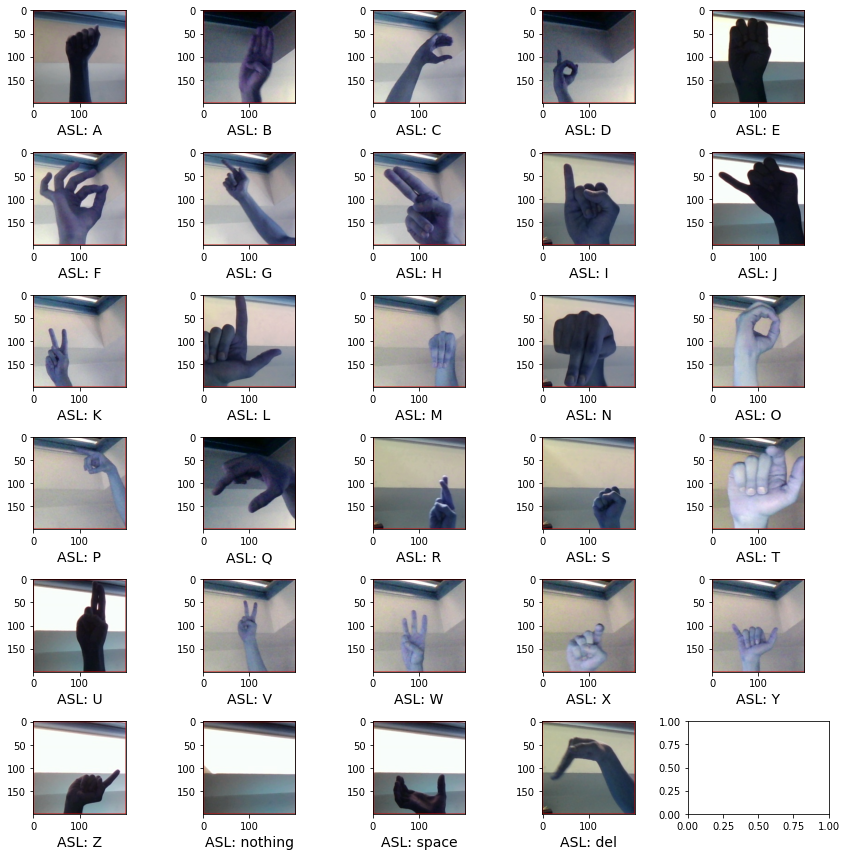

In [3]:
path='/content/ASL_Data_40K/archive_40k/asl_alphabet_train/asl_alphabet_train/'

X_train = []
y_train = []

labels = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P",
          "Q","R","S","T","U","V","W","X","Y","Z","nothing","space", "del"]

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(12, 12))
row = 0
col = 0
raw_image_list = []
c0_hist_list = []
c1_hist_list = []
c2_hist_list = []

label_ind_dict = {} # dictionary to hold the label to index mapping

for label in labels:
    # get a list of all images (.jpg files) in a directory using glob.glob
    examples = glob.glob(path+label+"/*.jpg")
    img_cnt = 0 # for each label start with img_cnt set to 0
    print_flag = np.random.randint(0, len(examples)-1) # randomly select image 
    for image in examples:
        y_train.append(label)
        image1 = cv2.imread(image)
        if print_flag == img_cnt: 
            raw_image_list.append(image1) # add the image to the raw_image_list
            label_ind_dict[label] = img_cnt - 1 # save the index for that label
            # calculate the RGB values for the image and append to a list
            c0_hist_list.append(cv2.calcHist([image1], [0], None, [256], 
                                             [0,256]))
            c1_hist_list.append(cv2.calcHist([image1], [1], None, [256], 
                                             [0,256]))
            c2_hist_list.append(cv2.calcHist([image1], [2], None, [256], 
                                             [0,256]))
            ax = axes[row, col]
            ax.imshow(image1, cmap="gray") 
            ax.set_xlabel('ASL: '+label, fontsize=14) 
            col += 1
            if col % 5 == 0:
                row += 1
                col = 0
        img_cnt += 1
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
        # gaussian blur
        image1 = cv2.GaussianBlur(image1.reshape(200,200), (5,5),0)
        image1 = cv2.Canny(image=image1.reshape(200,200), threshold1=100, 
                           threshold2=200)
        im_array = np.asarray(image1).reshape((200,200))
        X_train.append(im_array.flatten())
        
fig.tight_layout()
plt.show()

**Print sizes associated with the training data and the images inside training data**

In [4]:
# check the sizes of the trainining data 
print("Size of X_train:", len(X_train))
print("Size of y_train:", len(y_train))
print("Size of X_train entry:", len(X_train[0]))

Size of X_train: 87000
Size of y_train: 87000
Size of X_train entry: 40000


**Pick a random image to check gray scale conversion**

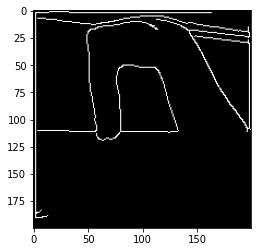

In [26]:
# check how the gray shades images show - pick a random one
plt.rc('image', cmap='gray')
plt.imshow(X_train[np.random.randint(1, len(X_train))].reshape(200,200))
plt.show()

**Gray scale images corresponding to the color images**

In this section we pick the gray scale image corresponding to the image we stored in *raw_image_list* variable earlier. We do this by looking at the index for each character in the variable *label_ind_dict* and matching that index to the index in the X_train variable, which holds all the gray scale images.

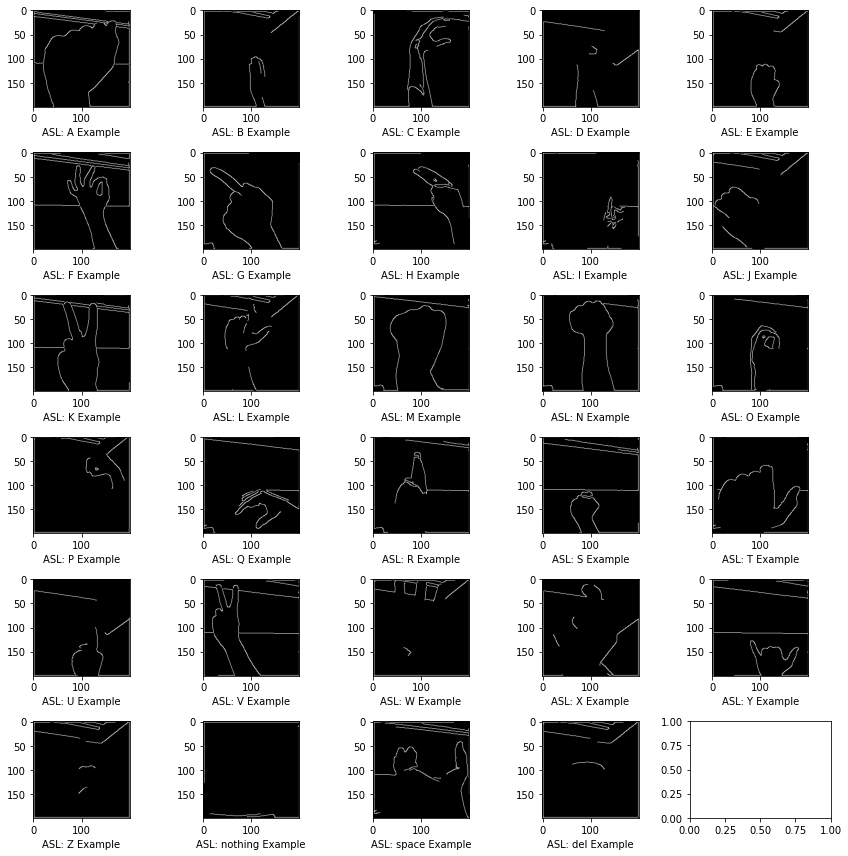

In [8]:
X_train = np.array(X_train)
y_train = np.array(y_train)

image_index_list = [] # init list to add digit example indexes to
# for each label find indices in y_train for that label and pick that 
# index that corresponds to label index that was printed earlier.
for label in labels:
    label_ind = np.where(y_train==label)[0][label_ind_dict[label]]
    image_index_list.append(label_ind)
    
plt.rc('image', cmap='gray')
fig, ax = plt.subplots(6, 5, figsize=(12,12))

counter = 0 # counter to be used for image index

for i in range(6):
    for num in range(5):
        if counter < 29:
            ind = image_index_list[counter]
            # Displaying image on correct subplot
            ax[i, num].imshow(X_train[ind].reshape(200,200))
            ax[i,num].set_xlabel('ASL: '+y_train[ind]+' Example')
            counter += 1

fig.tight_layout()
plt.show()

**RGB values for each image displayed earlier**

Use the variables c0_hist_list, c1_hist_list, and c2_hist_list to get the RGB histograms for each of the picture displayed earlier, in color. The image is laid out as 9 images per row, to fill in up to 29 images. 

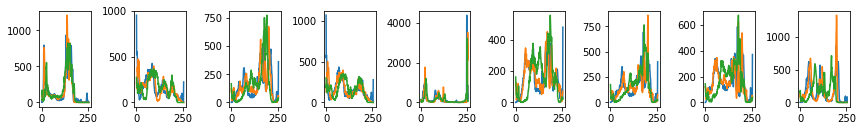

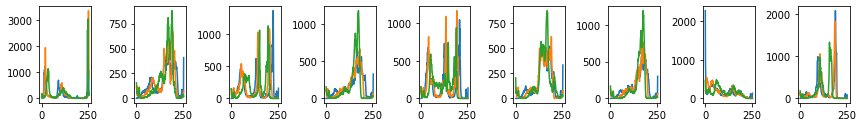

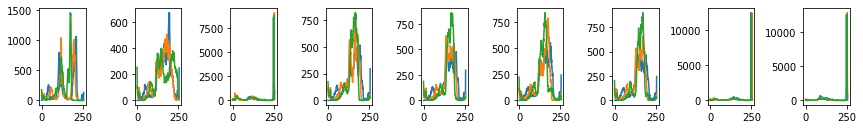

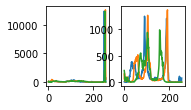

In [9]:
pos = 790 # control the positio of where we want to print the image
plt.figure(figsize=(12,12))
for i in range(len(raw_image_list)):
    pos += 1 # start with position 791: 9 images per row, starting from col 1
    plt.subplot(pos), plt.plot(c0_hist_list[i]), plt.plot(c1_hist_list[i]), 
    plt.plot(c2_hist_list[i])
    if pos == 799: # when 9 pictures have been accumulated
        pos = 790  # reset to 790, draw 
        plt.tight_layout() 
        plt.show() # draw the 9 pictures
        plt.figure(figsize=(12,12)) # reinit the drawing space

**For a random alphabet picked compare the original, and the gray scales, side-by-side.**

The letter chosen is: Q


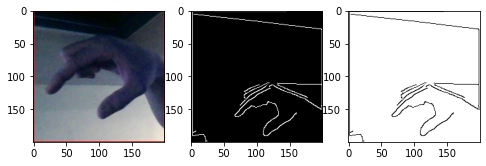

In [11]:
# Check the original image and gray scale images
rand_val = np.random.randint(0, 25) # pick a random letter
letter = labels[rand_val]
print("The letter chosen is:", letter)

fig, ax = plt.subplots(1, 3, figsize=(8,8))
plt.rc('image', cmap='gray')

ax[0].imshow(raw_image_list[rand_val]) # raw image

# get the index in y_train corresponding to the letter above
ind = np.where(y_train==letter)[0][label_ind_dict[letter]]
ax[1].imshow(X_train[ind].reshape(200,200)) # image with gray scale
ax[2].imshow(255 - X_train[ind].reshape(200,200)) 

plt.show()

In [12]:
np.random.seed(42)

**Shuffle the X_train and y_train data and split into training and test sets.**

In [13]:
# shuffle and split data set into training and testing data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_train, x_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                    test_size=0.25)

**Generate numeric labels corresponding to each alphabet**

In [14]:
le = sklearn.preprocessing.LabelEncoder()
le.fit(y_train)
print("Unqiue values of classes:")
print(le.classes_)
train_labels = le.transform(y_train)
test_labels = le.transform(y_test)
print("Associated label for each symbol:")
print(np.unique(train_labels))
print("Number of train samples:", len(train_labels))
print("Number of test samples:", len(test_labels))

Unqiue values of classes:
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' 'del' 'nothing' 'space']
Associated label for each symbol:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
Number of train samples: 65250
Number of test samples: 21750


**Given the size of the image (200x200) any regression will take a long time. So, use PCA 
for dimensionality reduction**

In [15]:
def pca_transform(train_data, test_data, explainability=.80, size=1000):
    pca = PCA(explainability)
    pca.fit(train_data[:size])
    train = pca.transform(train_data)
    test = pca.transform(test_data)
    print("Features Reduced to {} Principal Components".format(len(test[0])))
    return train, test

pca_train, pca_test = pca_transform(X_train, x_test)

Features Reduced to 416 Principal Components


In [29]:
print(pca_train.shape, pca_test.shape, pca_train[0].shape)

(65250, 416) (21750, 416) (416,)


**Initialize logistic regression, fit data, and predict based on test data**

**Note**: *Going forward we'll use the variable train_labels and test_labels which contain integers between 0 and 28.*

Letter A -> 0, Letter B -> 1, ..., Letter Z -> 25

Symbol for "del" -> 26, Symbol for "nothing" -> 27, Symbol for "space" -> 28

Some notes on the Logistic Regression

*  *solver* parameter should be set to *lbfgs*. In some older version of SKLEARN not setting the solver to lbfgs has 2 problems - one is that the default 'liblinear' is 40x to 50x slower, and the second is that liblinear doesn't work with multi-class problems. In the latest version of SKLEARN the default is lbfgs. 

**lbfgs** — *Limited-memory Broyden–Fletcher–Goldfarb–Shanno*. It approximates the 2nd derivative matrix updates with gradient evaluations. It stores only the last few updates, so it saves memory. It isn't super fast with large data sets (millions of samples). It will be the default solver as of Scikit-learn version 0.22. We chose this for the data set size of ~60K. Works well and produces good accuracy.

**newton-cg** — A newton method. Newton methods use an exact Hessian matrix. It's slow for large datasets, because it computes the 2nd derivatives. Has a high memory footprint.

**liblinear** — *Library for Large Linear Classification*. Uses a coordinate descent algorithm, based on minimizing a multivariate function by solving univariate optimization problems in a loop. It moves toward the minimum in one direction at a time. It is the default solver for Scikit-learn versions earlier than 0.22.0. It performs pretty well with high dimensionality; but has several drawbacks. It can get stuck in saddle points, is unable to run in parallel, and can only solve multi-class logistic regression with one-vs.-rest (OVR). Not suitable for what we're trying to do.

**sag** — *Stochastic Average Gradient* descent. A variation of gradient descent and incremental aggregated gradient approaches that uses a random sample of previous gradient values. Reasonably fast for big datasets.

**saga** — Extension of sag that also allows for L1 regularization. Should generally train faster than sag.

*   As for penalty leave it at default value of *l2*. If set to *l1* then lbfgs won't work.

solver='lbfgs' sets multi_class='auto'(default) and penatly='l2'(default) is what we used. When solver is set to lbfgs other parameters fall into place. 

The call - LogisticRegression(solver='lbfgs') is all that's needed to be set. We can skip specifying the solver parameter if SKLEARN version 0.22 or higher.

Refer to https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions/52388406#52388406 for detailed description on the solver, penalty, dataset size combination discussion.


In [16]:
clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, train_labels)

LogisticRegression()

In [17]:
y_pred = clf.predict(x_test)

**Compute metrics**

In [18]:
f1 = metrics.f1_score(test_labels, y_pred, average='weighted')
accuracy = metrics.accuracy_score(test_labels, y_pred)
precision = metrics.precision_score(test_labels, y_pred, average='weighted')

print("******Weighted Metrics********")
print('    F1-score: {:.4f}\n'.format(f1))
print('    Accuracy: {:.4f}\n'.format(accuracy))
print('    Precision: {:.4f}'.format(precision))

print()
print("*****All weighted scores - precision, recall, F1, and Support*****")
print(metrics.precision_recall_fscore_support(
    test_labels, y_pred, average='weighted'))

print()
f1_l = metrics.f1_score(test_labels, y_pred, average=None)
precision_l = metrics.precision_score(test_labels, y_pred, average=None)
print("******Per-label Metrics********")
print("     F1 score:")
print(f1_l)
print("     Precision:")
print(precision_l)

******Weighted Metrics********
    F1-score: 0.9152

    Accuracy: 0.9153

    Precision: 0.9155

*****All weighted scores - precision, recall, F1, and Support*****
(0.915462809984841, 0.9153103448275862, 0.915248695668256, None)

******Per-label Metrics********
     F1 score:
[0.84268126 0.83504449 0.88147139 0.88449266 0.90718954 0.92899023
 0.90287278 0.90627202 0.9237785  0.90885246 0.93264249 0.95159059
 0.9153605  0.95663601 0.91505017 0.95448461 0.9650924  0.96102151
 0.94418292 0.9442623  0.91031693 0.86342438 0.8707124  0.88466948
 0.88279644 0.95244216 0.92051282 0.98853675 0.90326885]
     Precision:
[0.86760563 0.81769437 0.89118457 0.86951066 0.90718954 0.92
 0.92050209 0.90947666 0.90203562 0.91184211 0.93143596 0.95159059
 0.91364205 0.97066667 0.912      0.94687915 0.97375691 0.95973154
 0.95121951 0.9375     0.90604027 0.85941645 0.89430894 0.89346591
 0.87027027 0.94274809 0.91698595 0.98389262 0.91117093]


**Compute the confusion matrix and draw the heatmap**

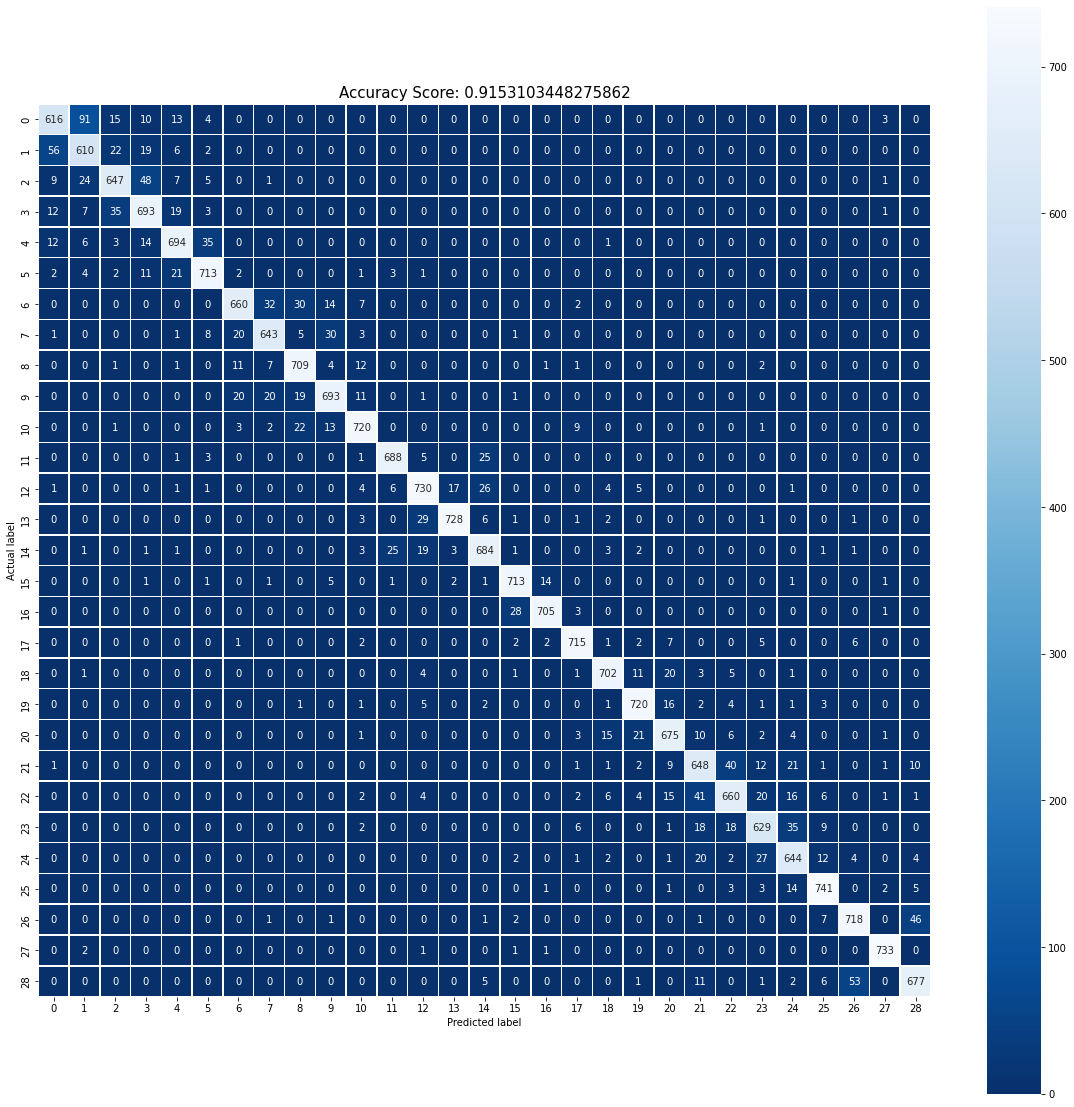

In [19]:
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt="0.0f", linewidths=.5, square = True, 
            cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title_cm = 'Accuracy Score: {0}'.format(accuracy)
plt.title(title_cm, size = 15);

**Run logistic regression with PCA reduced images and report scores**

Here we run with C=1.0 (default) to make a comparison of the performance between original 200x200 image and the PCA-reduced data.

In [63]:
clf_pca = LogisticRegression(solver='lbfgs')
clf_pca.fit(pca_train, train_labels)
y_pred_pca = clf_pca.predict(pca_test)

f1 = metrics.f1_score(test_labels, y_pred_pca, average='weighted')
accuracy = metrics.accuracy_score(test_labels, y_pred_pca)
precision = metrics.precision_score(test_labels, y_pred_pca, average='weighted')

print("******Weighted Metrics********")
print('    F1-score: {:.4f}\n'.format(f1))
print('    Accuracy: {:.4f}\n'.format(accuracy))
print('    Precision: {:.4f}'.format(precision))

print()
print("*****All weighted scores - precision, recall, F1, and Support*****")
print(metrics.precision_recall_fscore_support(
    test_labels, y_pred_pca, average='weighted'))

print()
f1_l = metrics.f1_score(test_labels, y_pred_pca, average=None)
precision_l = metrics.precision_score(test_labels, y_pred_pca, average=None)
print("******Per-label Metrics********")
print("     F1 score:")
print(f1_l)
print("     Precision:")
print(precision_l)

******Weighted Metrics********
    F1-score: 0.8826

    Accuracy: 0.8826

    Precision: 0.8830

*****All weighted scores - precision, recall, F1, and Support*****
(0.8829814005111876, 0.8826206896551724, 0.8826424184822222, None)

******Per-label Metrics********
     F1 score:
[0.7699594  0.75720165 0.85503356 0.83301344 0.87607687 0.92002644
 0.88158795 0.87889273 0.9073107  0.88384166 0.91567852 0.9280329
 0.87111111 0.90105541 0.86870027 0.92718771 0.94508475 0.93703453
 0.93226023 0.91469816 0.879526   0.84574468 0.84569928 0.82729805
 0.83215797 0.91607027 0.89601046 0.99186992 0.85340314]
     Precision:
[0.78374656 0.74293405 0.85160428 0.82093317 0.88844086 0.92430279
 0.89944134 0.86630286 0.88761175 0.87757732 0.93038822 0.91983696
 0.88061617 0.91801075 0.85845347 0.91798942 0.94444444 0.94277929
 0.93665768 0.90873533 0.8553137  0.84015852 0.86442953 0.82729805
 0.84406295 0.9178618  0.91090426 0.99186992 0.84455959]


**Run the Logistic Regression with different C values**

We choose to run with the PCA-reduced data set due to the time it takes with the 200x200 images.

In [60]:
f1 = []
accuracy = []
precision = []
run_time = []

c_val = [0.01, 0.1, 0.5, 0.75, 1, 1.5, 2.0]
#c_val = [0.1, 0.5]

for c in c_val:
  start_time = time.time()

  clf_pca = LogisticRegression(C= c, solver='lbfgs') 
  clf_pca.fit(pca_train, train_labels)
  y_pred_pca = clf_pca.predict(pca_test)

  run_time.append(time.time() - start_time)

  f = metrics.f1_score(test_labels, y_pred_pca, average='weighted')
  acc = metrics.accuracy_score(test_labels, y_pred_pca)
  p = metrics.precision_score(test_labels, y_pred_pca, average='weighted')
  f1.append(f)
  accuracy.append(acc)
  precision.append(p)

df = pd.DataFrame(
    { "c_value": c_val,
      "f1_score": f1,
      "accuracy_val": accuracy,
      "precision_val": precision,
      "execution_time": run_time}
)
print(df)

   c_value  f1_score  accuracy_val  precision_val  execution_time
0     0.01  0.882453      0.882437       0.882886       37.013462
1     0.10  0.883320      0.883310       0.883713       36.593505
2     0.50  0.882562      0.882529       0.882948       36.725066
3     0.75  0.882519      0.882483       0.882907       36.886636
4     1.00  0.882642      0.882621       0.882981       37.004272
5     1.50  0.882942      0.882943       0.883274       37.087731
6     2.00  0.884196      0.884184       0.884540       36.753667


**Confusion matrix computation**

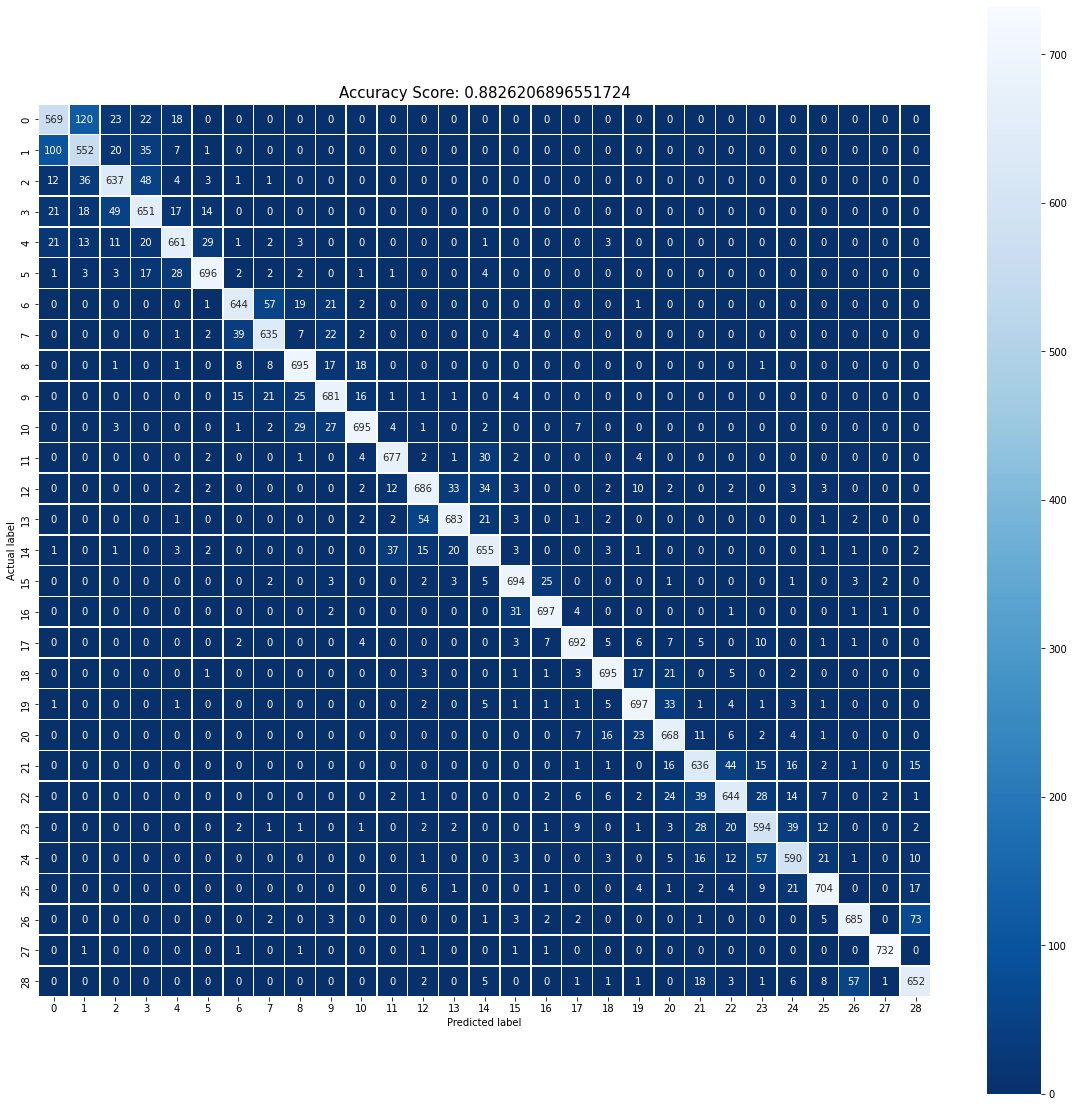

In [21]:
cm = confusion_matrix(test_labels, y_pred_pca)
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt="0.0f", linewidths=.5, square = True, 
            cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title_cm = 'Accuracy Score: {0}'.format(accuracy)
plt.title(title_cm, size = 15);

**Generate the AUC-ROC curve**

In this section we'll randomly choose a character and compare the AUC-ROC curve between the full (200x200) image and the PCA-reduced version.

In [22]:
pred_prob = clf.predict_proba(x_test)

fpr = {}
tpr = {}
thresh ={}

for i in range(len(np.unique(test_labels))):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_labels, pred_prob[:,i], 
                                          pos_label=i)
    
pred_prob_pca = clf_pca.predict_proba(pca_test)

fpr_pca = {}
tpr_pca = {}
thresh_pca ={}

for i in range(len(np.unique(test_labels))):    
    fpr_pca[i], tpr_pca[i], thresh_pca[i] = roc_curve(test_labels, 
                                                      pred_prob_pca[:,i], 
                                                      pos_label=i)

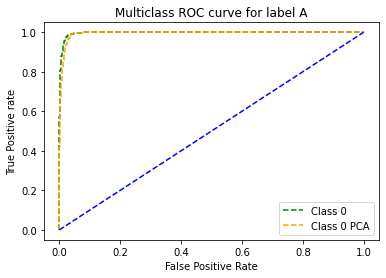

In [46]:
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(test_labels, random_probs, pos_label=1)

rand_val = np.random.randint(0, 28)
plt.plot(fpr[rand_val], tpr[rand_val], linestyle='--',color='green', 
         label='Class '+ str(rand_val))
plt.plot(fpr_pca[rand_val], tpr_pca[rand_val], linestyle='--', color='orange', 
         label='Class ' + str(rand_val) + ' PCA')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('Multiclass ROC curve for label ' + labels[rand_val])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

**AUC-ROC curves for each character for the case of full (200x200) image**

The X-axis and y-axis values are being limited to a range that shows the deviations for each character well.

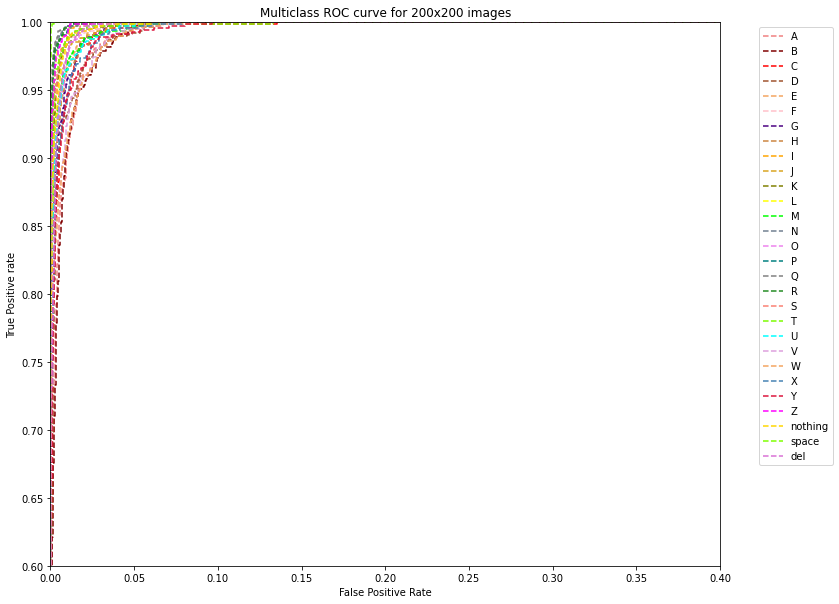

In [59]:
palette = ['lightcoral', 'maroon', 'red', 'sienna', 'sandybrown', 'pink',
           'indigo', 'peru', 'orange', 'goldenrod', 'olive', 'yellow',
           'lime', 'slategray', 'violet', 'teal', 'gray', 'forestgreen',
           'salmon', 'lawngreen', 'cyan', 'plum', 'sandybrown', 'steelblue',
           'crimson', 'magenta', 'gold', 'chartreuse', 'orchid']

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(test_labels, random_probs, pos_label=1)

plt.figure(figsize=(12,10))

for i in range(29):
  plt.plot(fpr[i], tpr[i], linestyle='--',color=palette[i], 
         label=labels[i])
  plt.plot(p_fpr, p_tpr, linestyle='--', color='blue') 
  plt.title('Multiclass ROC curve for 200x200 images')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.xlim(0, 0.4)
  plt.ylim(0.6, 1)
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.show()               

**AUC-ROC curves for each character for the case of PCA-reduced image**

The X-axis and y-axis values are being limited to a range that shows the deviations for each character well.

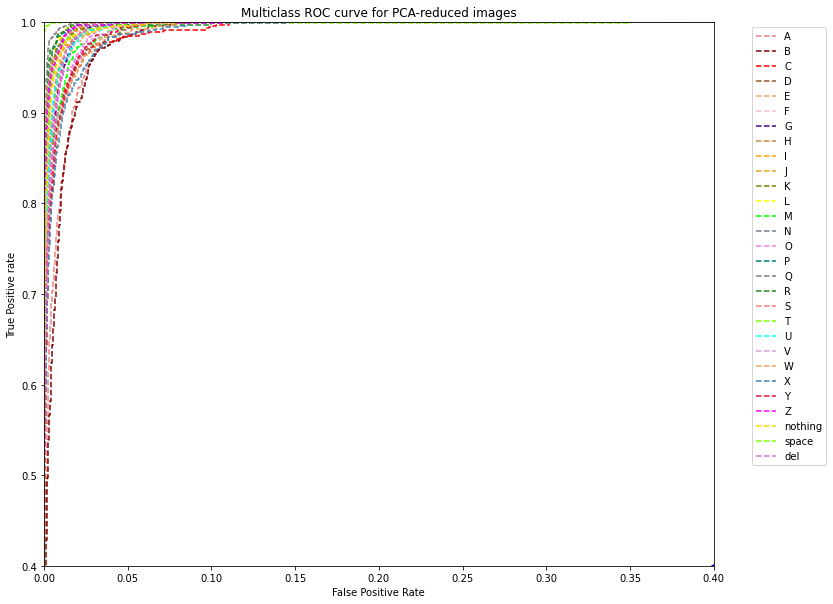

In [58]:
palette = ['lightcoral', 'maroon', 'red', 'sienna', 'sandybrown', 'pink',
           'indigo', 'peru', 'orange', 'goldenrod', 'olive', 'yellow',
           'lime', 'slategray', 'violet', 'teal', 'gray', 'forestgreen',
           'salmon', 'lawngreen', 'cyan', 'plum', 'sandybrown', 'steelblue',
           'crimson', 'magenta', 'gold', 'chartreuse', 'orchid']

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(test_labels, random_probs, pos_label=1)

plt.figure(figsize=(12,10))

for i in range(29):
  plt.plot(fpr_pca[i], tpr_pca[i], linestyle='--',color=palette[i], 
         label=labels[i])
  plt.plot(p_fpr, p_tpr, linestyle='--', color='blue') 
  plt.title('Multiclass ROC curve for PCA-reduced images')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.xlim(0, 0.4)
  plt.ylim(0.4, 1)
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.show()               

**Sum of squared weights for the non-PCA and PCA models**

In [28]:
print("Sum of squares of weights")
sum_sq_wt = []
sum_sq_wt_pca = []
for i in range(len(np.unique(test_labels))):
    sum_sq_wt.append(round(np.sum(clf.coef_[i]**2), 4))
    sum_sq_wt_pca.append(round(np.sum(clf_pca.coef_[i]**2), 4))

df = pd.DataFrame({"sum_square_weights": sum_sq_wt,
     "sum_square_weights_pca": sum_sq_wt_pca})
print(df)

Sum of squares of weights
    sum_square_weights  sum_square_weights_pca
0               0.0023                  0.0037
1               0.0023                  0.0036
2               0.0020                  0.0034
3               0.0019                  0.0028
4               0.0018                  0.0029
5               0.0017                  0.0033
6               0.0020                  0.0022
7               0.0021                  0.0027
8               0.0017                  0.0027
9               0.0018                  0.0027
10              0.0016                  0.0030
11              0.0015                  0.0029
12              0.0019                  0.0029
13              0.0019                  0.0029
14              0.0016                  0.0026
15              0.0020                  0.0031
16              0.0015                  0.0027
17              0.0017                  0.0030
18              0.0015                  0.0032
19              0.0014            